In [1]:
import sys
import LangtjernWeather as lw
import numpy as np
import datetime
import pandas as pd
import getpass
import matplotlib
import matplotlib.pyplot as plt
import getpass
import itertools as IT
from itertools import compress
from matplotlib import rc
import shutil
import os
import re
import pickle
import pylab
import statsmodels.api as sm
from patsy import dmatrices
import instantiationFimex as fimex
from subprocess import Popen, PIPE, CalledProcessError
import xarray as xr

#Setting matplotlib style
matplotlib.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None
rc('text', usetex=True)
rc('xtick', labelsize = 16)
rc('ytick', labelsize = 16)
rc('font', size = 16)
#login function
def login():
    username = input("Username: [JLG] ") #default username JLG
    if not username :
        username = "JLG"
    password = getpass.getpass('Password: ')
    return username, password

#Creating directories to store files. This will overwrite if the directory already exists
def create_dir(dir_name) :
    if not os.path.exists(dir_name) :
        os.makedirs(dir_name)
    else :
        shutil.rmtree(dir_name)
        os.makedirs(dir_name)
#Helper function for plotting
def plot_df(df) :
    num_cols = len(df.columns)
    fig, axes = plt.subplots(nrows = num_cols, ncols = 1, figsize = (20, num_cols * 5))
    for name,ax_h in zip(df.columns, axes) :
        plt.sca(ax_h)
        plt.plot(df.index,df[name])
        #df[name].plot(ax = ax_h)
        ax_h.set_ylabel(name)
    return fig

def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

#Sanity check
print("Using python version:")
print(sys.version)
print("Paths to python libraries:")
print(sys.path)

#Creating directory to save results
result_dir = './results/'
create_dir(result_dir)    

Using python version:
3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
Paths to python libraries:
['', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python36.zip', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages/IPython/extensions', '/home/jose-luis/.ipython']


# Creating data files for GOTM ∕ FABM
## Credentials for Aquamonitor

In [2]:
username,password = login()

#Folder where the downloaded data will be saved
root = "./DownloadedData/"
create_dir(root)

Username: [JLG]  
Password:  ··············


## Defining period to download
This should be the same as in the "Catchment_and_weather" notebook

In [3]:
now = pd.to_datetime('today').strftime('%Y-%m-%d')
#datesToGet = '2019-01-01/{}'.format(now)
datesToGet = '2010-01-01/{}'.format(now)
start = datesToGet.split('/')

finish = pd.datetime.strptime(start[1],'%Y-%m-%d')
start = pd.datetime.strptime(start[0],'%Y-%m-%d')

# finish_dt = pd.datetime.strftime(finish,'%Y-%m-%d')
# start_dt = pd.datetime.strftime(start,'%Y-%m-%d')
# display(finish)

## Downloading meteo data measured locally at Langtjern

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7effd1a50da0>,
      dtype=object)

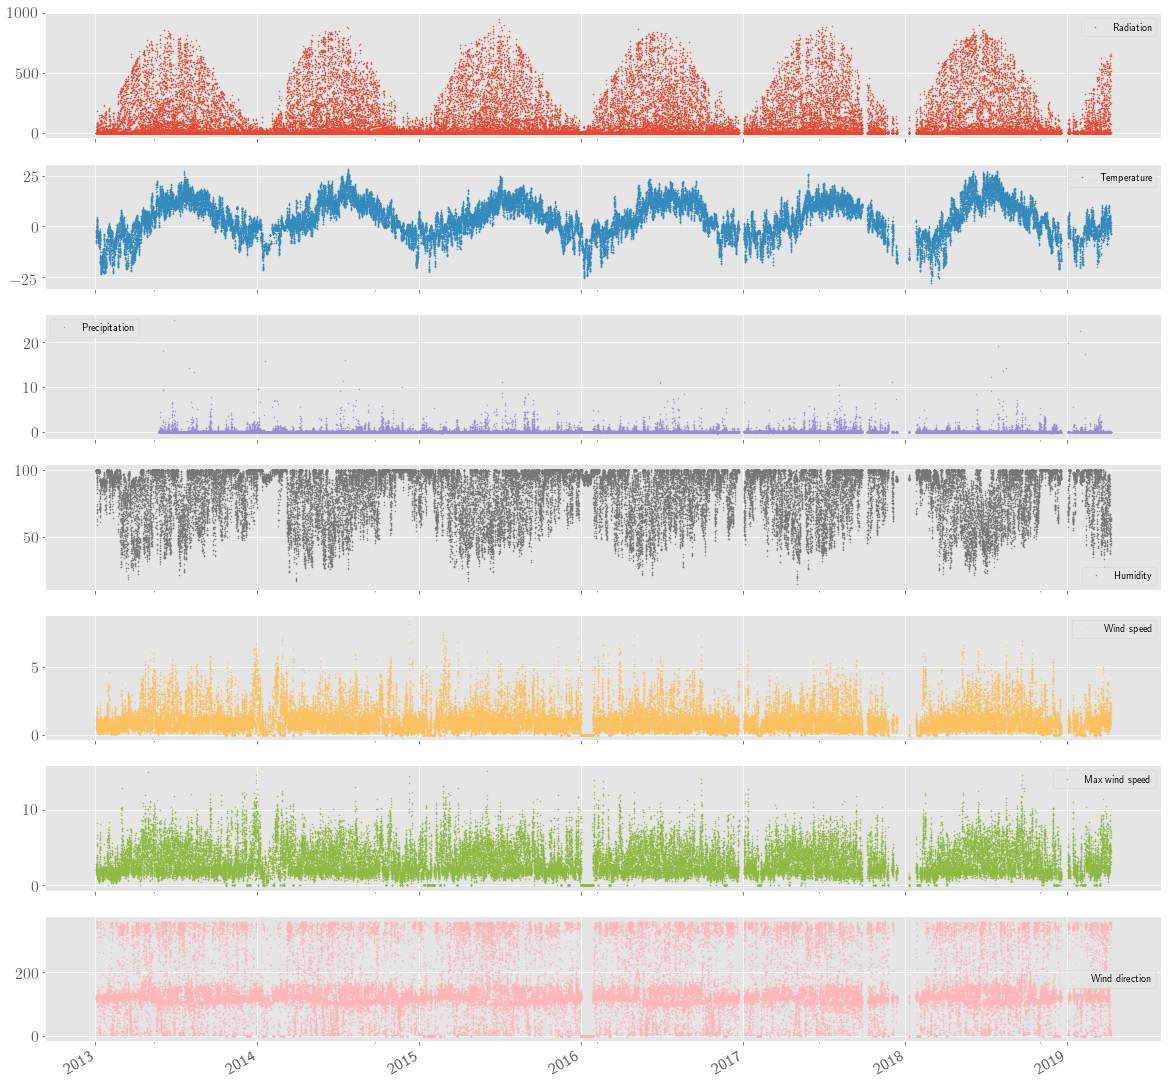

In [4]:
lake = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'),
                           62040,
                           'Air')
lake.drop(['ProjectId','ProjectName','StationId','StationCode','StationName','SampleDate_dato','SampleDate_tid'],
         inplace=True, axis=1)
lake.columns = lake.columns.str.strip()
lake.rename(columns={'Lufttemperatur_°C': 'Temperature',
                     'Globalstråling_W/m2' : 'Radiation',
                     'Nedbør_mm' : 'Precipitation',
                     'Relativ luftfuktighet_%': 'Humidity',
                      'Vindhastighet_m/s' : 'Wind speed',
                     'Vindhastighet (maks)_m/s' : 'Max wind speed',
                     'Vindretning_°' : 'Wind direction'                    
                    },
            inplace=True)

#display(lake)
lake.plot(subplots=True,figsize=(20,3*lake.shape[1]),
          marker='.',
          markersize=1,
          linestyle='None')

## Using data from nearby stations to patch time series

In [5]:
filename = 'metno.pickle'
with open(filename, "rb") as f:
    meta,data = pickle.load(f) 

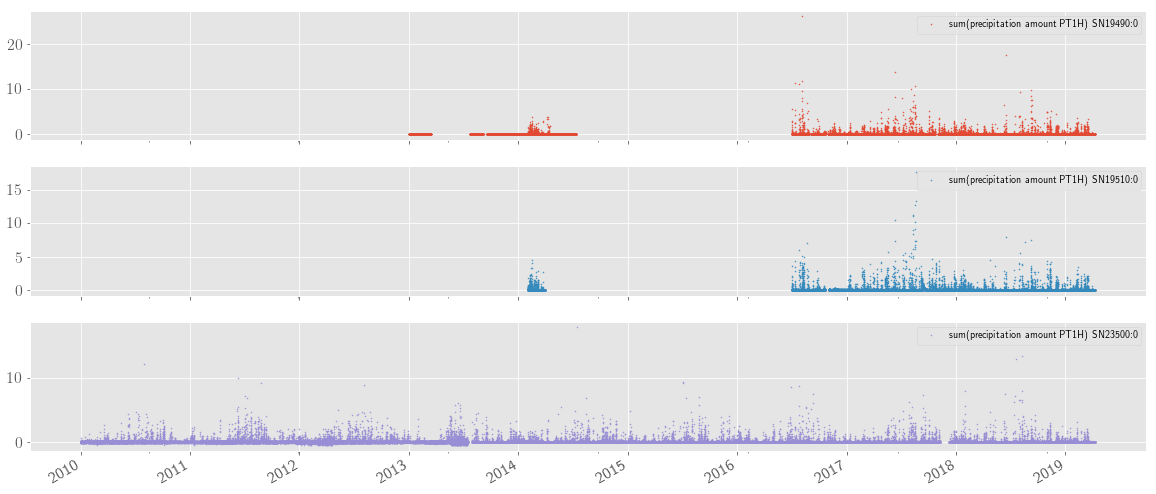

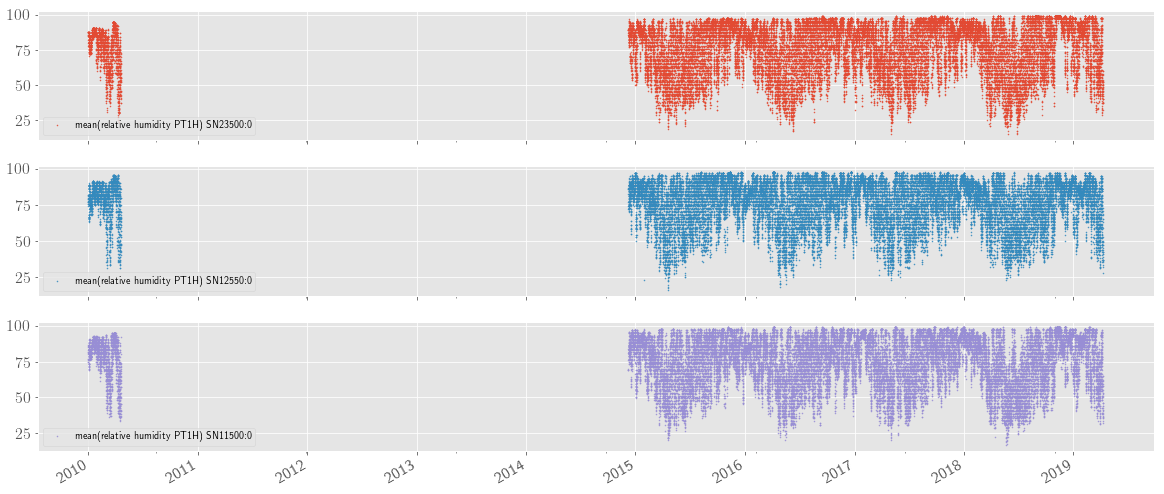

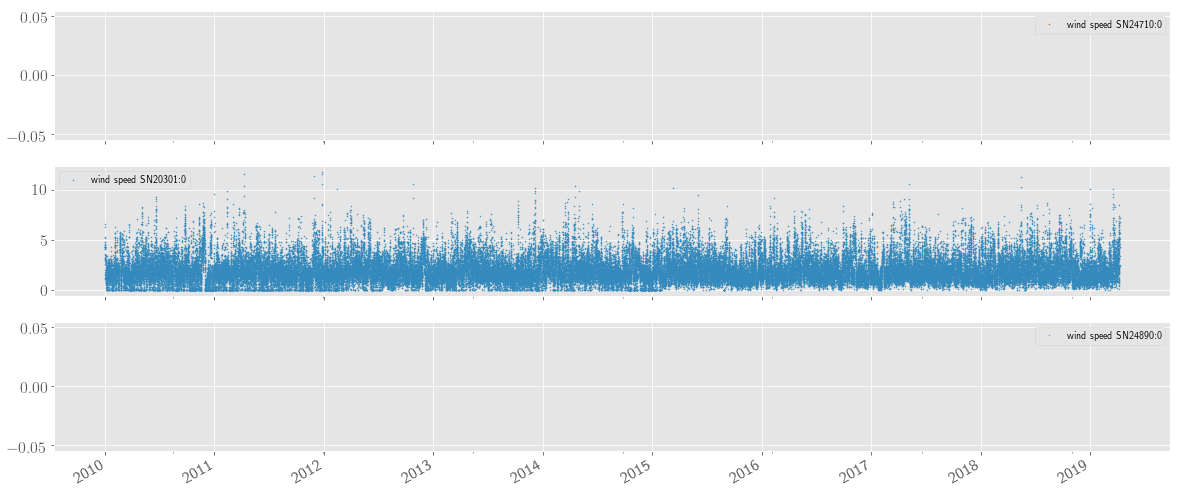

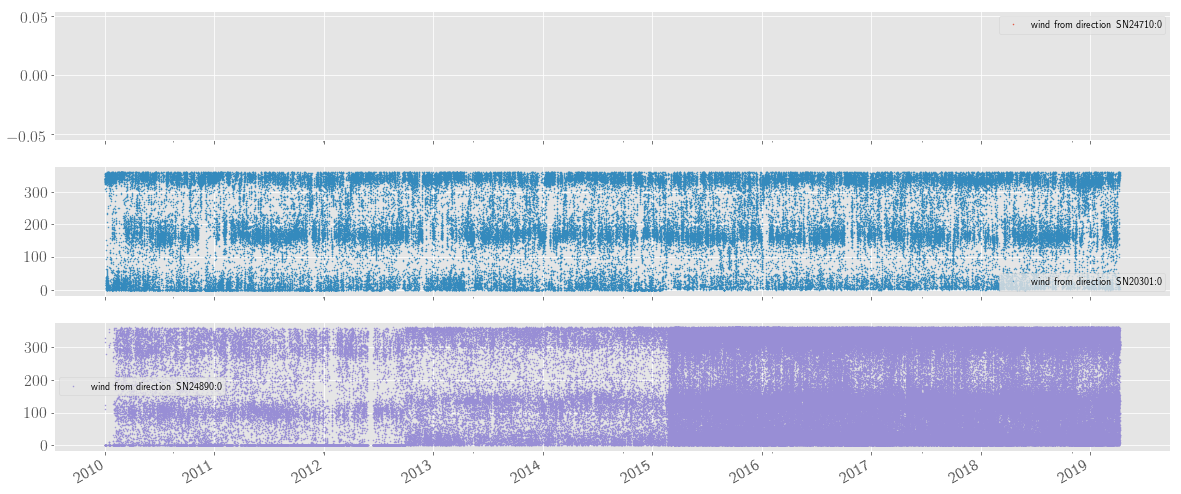

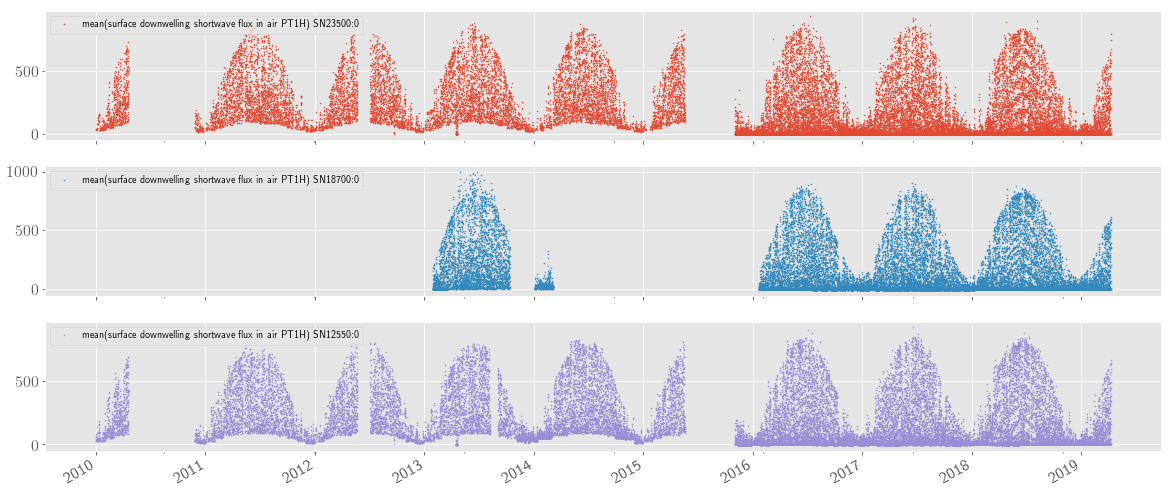

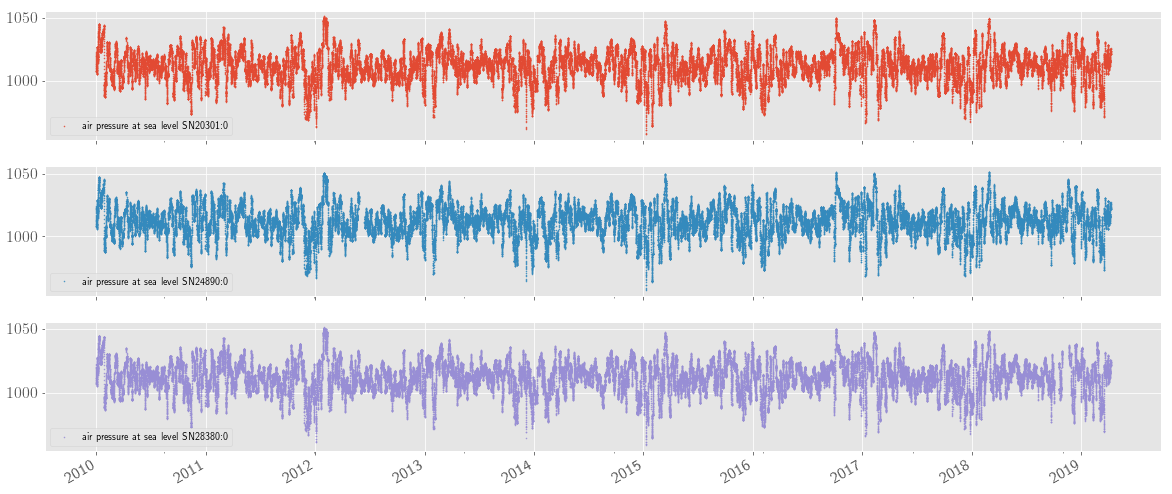

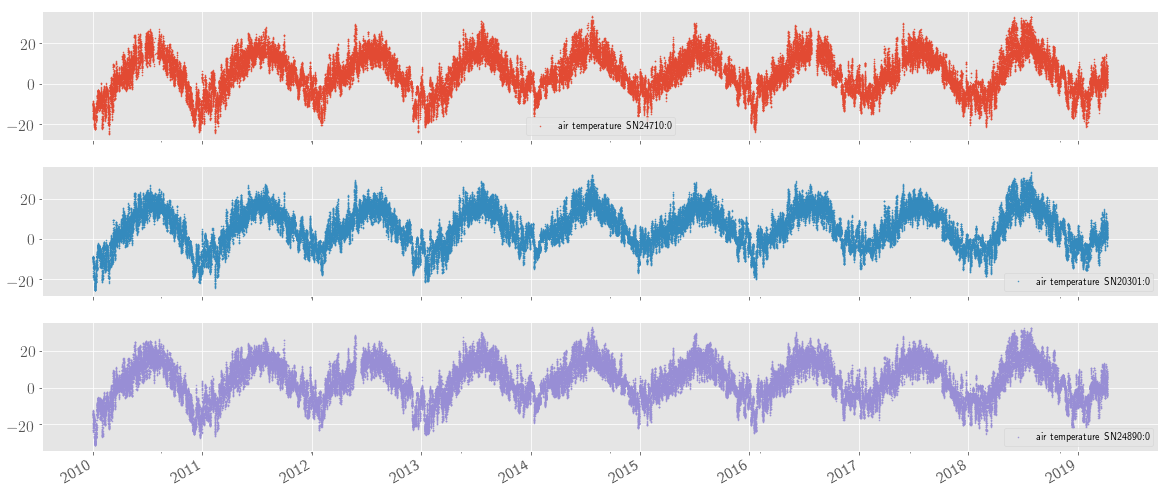

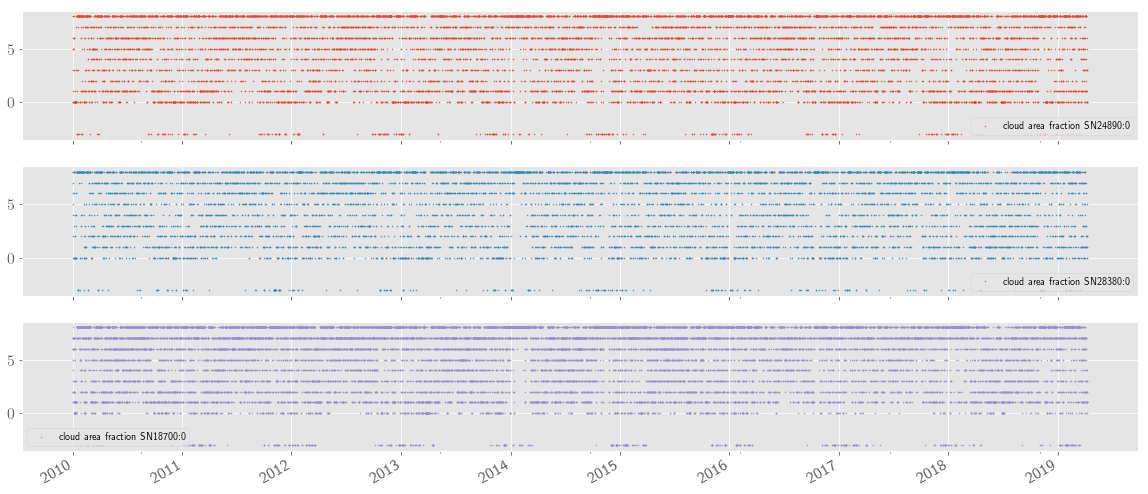

In [6]:
def plotVar(variable):
    data[variable].plot(subplots=True,
                           figsize=(20,3*len(data[variable].columns)),
                           marker='.',
                           markersize=1,                           
                           linestyle='None'
                       )    
for key,df in data.items():
    df.columns = df.columns.str.strip().str.replace('_',' ')
    plotVar(key)

### Patching precipitation
Patching precipitation from nearby stations is a silly endeavor. Instead we are getting daily data from when there are missing data and distributing it evenly during the day. We extract the precipition from metno's gridded dataset

In [7]:
# display(lake.columns)
startDf = lake['Precipitation'].index[0]
endDf = lake['Precipitation'].index[-1]

predictors = data['precipitation']
predictors.columns = ['a','b','c']
precipitation = pd.concat([lake['Precipitation'].to_frame(),predictors],axis=1, join='inner')
precipitation.dropna(inplace=True)
y, X = dmatrices('Precipitation ~ 0 + a + b + c', data=precipitation)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Precipitation   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     1448.
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        13:52:20   Log-Likelihood:                -16323.
No. Observations:               21584   AIC:                         3.265e+04
Df Residuals:                   21581   BIC:                         3.268e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
a              0.1405      0.009     15.498      0.000       0.123       0.158
b              0.1994      0.010     20.278      0.000       0.180       0.219
c              0.3372      0.009     35.730      0.000       0.319       0.356
==============================================================================
Omnibus:                    44452.164   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        254128918.411
Skew:                          17.247   Prob(JB):                         0.00
Kurtosis:                     533.457   Cond. No.                         2.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It makes no sense to patch hourly precipitation with precipitation from nearby stations. We will instead use data from from the nordic gridded dataset. 

#### Instantiating machine to download data from metno's thredds servers

In [8]:
instance = 'prognos-fimex'
username = 'jose-luis'
keyDir = 'prognosFimex'
region = 'europe-west3-b'
machineType = 'n1-standard-4'

fimexGenerator = fimex.fimex(instance,username,region,keyDir,machineType)
fimexGenerator.instantiate()
print("The ip of the google cloud instance is {}".format(fimexGenerator.ip))

#Testing connection to instance

if fimexGenerator.instanceExists:
    p = Popen("ssh -i {0}/{1} {1}@{2} -o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no".format(
            fimexGenerator.keyDir,
            fimexGenerator.username,
            fimexGenerator.ip
            ),
            shell=True,stdout=PIPE,stdin=PIPE)
    print(p.communicate())

Creating instance prognos-fimex...
NAME           ZONE            MACHINE_TYPE   PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
prognos-fimex  europe-west3-b  n1-standard-4               10.156.15.213  35.246.195.89  RUNNING
Created [https://www.googleapis.com/compute/beta/projects/nivacatchment/zones/europe-west3-b/instances/prognos-fimex].
 - Disk size: '50 GB' is larger than image size: '10 GB'. You might need to resize the root repartition manually if the operating system does not support automatic resizing. See https://cloud.google.com/compute/docs/disks/persistent-disks#repartitionrootpd for details.

(b"Generating public/private rsa key pair.\nYour identification has been saved in /home/jose-luis/.ssh/prognosFimex/jose-luis.\nYour public key has been saved in /home/jose-luis/.ssh/prognosFimex/jose-luis.pub.\nThe key fingerprint is:\nSHA256:CpiDuTN4Z5CnHUX/dAOJ4eGgF+8N5y/4rXd77Jn2npo jose-luis\nThe key's randomart image is:\n+---[RSA 2048]----+\n|      + oo..     |\n|     o B.

In [9]:
#This is not working yet
cfg = 'interpolate.cfg'
file = open('interpolate.cfg','w') 
file.write('[interpolate]\n') 
file.write('latitudeValues = {}\n'.format('60.372670')) 
file.write('longitudeValues = {}\n'.format('9.726640')) 
file.close()

fimexGenerator.setFabfile('fabfile_fimex-bak.py ')

fimexGenerator.setCommand('''fab getDataForCoordinates:{},{},{},{},{} '''.format('precip_files_type1.txt',
                                                               cfg,
                                                               './precip_nc',
                                                               'precip_all.nc',
                                                                 'dummy'
                                                                            )
                     )
fimexGenerator.callPopen(verbose=True,overwrite=True)

'[35.246.195.89] run: rm -rf ./precip_nc\n'


Fatal error: Low level socket error connecting to host 35.246.195.89 on port 22: Unable to connect to port 22 on 35.246.195.89 (tried 1 time)

Underlying exception:
    Unable to connect to port 22 on 35.246.195.89

Aborting.


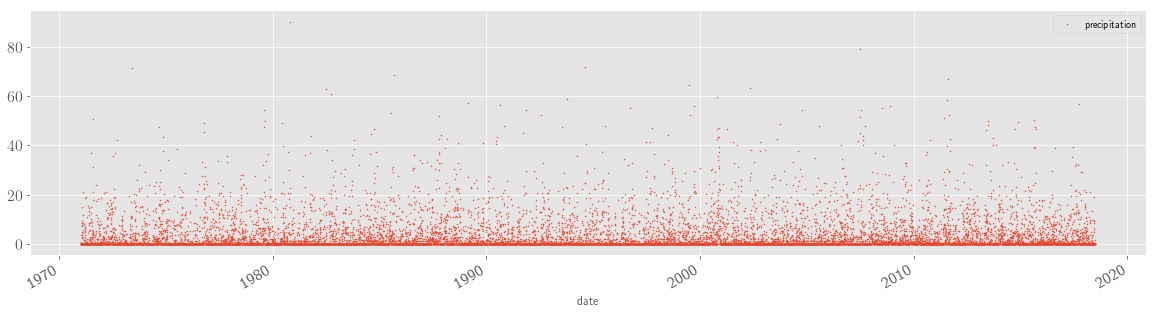

In [10]:
nc_file = precip = './precip.nc'
nc_data = xr.open_dataset(nc_file)
precipitation = nc_data.RR.isel(x=0,y=0)
precip_time = nc_data.time

dailyPrecip = pd.DataFrame({'date':precip_time, 'precipitation': precipitation})
dailyPrecip.set_index('date', inplace = True)
dailyPrecip.plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

#### Actually patching

In [11]:
filledPrecip = pd.date_range(startDf, endDf, freq='H')
filledPrecip = pd.DataFrame(index = filledPrecip)
filledPrecip = pd.merge(filledPrecip,lake['Precipitation'].to_frame(),left_index = True, right_index = True, how = 'left')   

def hourlyPrecip(date):
    currentDay = pd.Timestamp(date.year,date.month,date.day,18);
    nextDay = currentDay + datetime.timedelta(days=1)
    if currentDay in dailyPrecip.index and date.hour <= 18:
        return dailyPrecip.loc[currentDay,'precipitation']/24
    elif date.hour > 18 and nextDay in dailyPrecip.index:
            return dailyPrecip.loc[nextDay,'precipitation']/24
    else:
        return np.nan
        
    
date = pd.Timestamp(2015,1,1)
filledPrecip['dummy']=filledPrecip.index
filledPrecip['dummy'] = filledPrecip['dummy'].apply(hourlyPrecip)

filledPrecip[np.isnan(filledPrecip.Precipitation)].Precipitation = filledPrecip[np.isnan(filledPrecip.Precipitation)].dummy.values
display(filledPrecip)

# filledPrecip['Precipitation'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

,Precipitation,dummy
2013-01-02 13:00:00,NaN,0.2125
2013-01-02 14:00:00,NaN,0.2125
2013-01-02 15:00:00,NaN,0.2125
2013-01-02 16:00:00,NaN,0.2125
2013-01-02 17:00:00,NaN,0.2125
2013-01-02 18:00:00,NaN,0.2125
2013-01-02 19:00:00,NaN,0.0000
2013-01-02 20:00:00,NaN,0.0000
2013-01-02 21:00:00,NaN,0.0000
2013-01-02 22:00:00,NaN,0.0000


### Patching humidity

In [12]:
startDf = lake['Humidity'].index[0]
endDf = lake['Humidity'].index[-1]

predictors = data['humidity']
predictors.columns = ['a','b','c']
humidity = pd.concat([lake['Humidity'].to_frame(),predictors],axis=1, join='inner')
humidity.dropna(inplace=True)
y, X = dmatrices('Humidity ~ 0 + a + b + c', data=humidity)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Humidity   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.209e+06
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        13:52:56   Log-Likelihood:            -1.2380e+05
No. Observations:               35051   AIC:                         2.476e+05
Df Residuals:                   35048   BIC:                         2.476e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
a              0.5136      0.004    120.340      0.000       0.505       0.522
b              0.2396      0.006     39.313      0.000       0.228       0.252
c              0.3404      0.007     50.592      0.000       0.327       0.354
==============================================================================
Omnibus:                     1030.862   Durbin-Watson:                   0.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2268.665
Skew:                           0.167   Prob(JB):                         0.00
Kurtosis:                       4.201   Cond. No.                         26.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

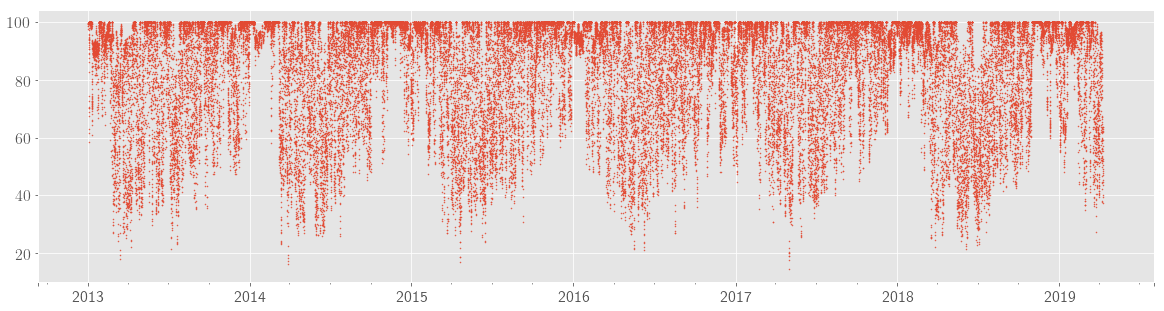

In [13]:
filledHumidity = pd.date_range(startDf, endDf, freq='H')
filledHumidity = pd.DataFrame(index = filledHumidity)
filledHumidity=pd.merge(filledHumidity,lake['Humidity'].to_frame(),left_index = True, right_index = True, how = 'left')     
filledHumidity = pd.concat([filledHumidity,data['humidity']], axis = 1, join_axes = [filledHumidity.index])


filledHumidity['Humidity'] = filledHumidity.apply(lambda row : np.float64(min(model.predict(row[['a','b','c']].values),100.)) 
                                                   if np.isnan(row['Humidity']) and np.logical_not(np.isnan(row.values[1:]).any()) 
                                                   else row['Humidity'],
                                                   axis=1)
#display(filledHumidity)
#filledHumidity=filledHumidity.astype('float')
filledHumidity['Humidity'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

In [14]:
display(filledHumidity.isnull().sum())
filledHumidity['Humidity'].interpolate(method='time',inplace=True)

Humidity      346
a           16946
b           17143
c           16964
dtype: int64

### Patching wind speed

In [15]:
startDf = lake['Wind speed'].index[0]
endDf = lake['Wind speed'].index[-1]

predictors = data['wind_speed']
predictors.columns = ['a','b','c']
ws = pd.concat([lake['Wind speed'].to_frame(),predictors],axis=1, join='inner')
ws.dropna(inplace=True)
ws.columns = ws.columns.str.replace(' ','_')
y, X = dmatrices('Wind_speed ~ a + b + c  - 1', data=ws)

model = sm.OLS(y, X).fit()
model.summary()

ValueError: negative dimensions are not allowed

In [ ]:
filledWind = pd.date_range(startDf, endDf, freq='H')
filledWind = pd.DataFrame(index = filledWind)

filledWind=pd.merge(filledWind,lake['Wind speed'].to_frame(),left_index = True, right_index = True, how = 'outer')
filledWind = pd.concat([filledWind,data['wind_speed']], axis = 1, join_axes = [filledWind.index])
#filledWind = pd.merge(filledWind,temp,left_index = True, right_index = True, how = 'inner')

#patching if an entire day with no wind
group = filledWind.groupby('Wind speed')
idx = np.cumsum(np.diff(group.indices[0.0]) != 1)
idx = np.insert(idx,0,1) if idx[1] != idx[0] else np.insert(idx,0,0)
val, count = np.unique(idx, return_counts = True)
#Filling only if there are more than 24 hours missing
valToFill = val[count >= 24]
allIdx = [group.indices[0.0][np.equal(idx,i)] for i in valToFill]
allIdx = np.concatenate(allIdx).ravel().tolist()
#np.set_printoptions(threshold=np.nan)
#display(allIdx[0],group.indices[0.0])
#display(allIdx)


filledWind['Wind speed'] = filledWind.apply(lambda row : np.float64(model.predict(row[['a','b','c']].values)) #np.float64(model.predict(row[['a','b','a:b','c','a:c','b:c','a:b:c']].values))
                                                   if np.isnan(row['Wind speed']) and np.logical_not(np.isnan(row.values[1:]).any()) 
                                                   else row['Wind speed'],
                                                   axis=1
                                           )
#Filling if there is more than a day without wind
display(model.params)
filledWind.iloc[allIdx,0] = filledWind['a'] * model.params[0] + filledWind['b'] + model.params[1] + filledWind['c'] * model.params[2]
view=filledWind[pd.Timestamp('2016-01-01'):pd.Timestamp('2016-03-01')].copy()

fig = plt.figure(figsize=(20,5))
plt.plot(view.index,view['Wind speed'],marker='.',markersize=1,linestyle='None')


# view['a'].plot(figsize=(20,5),
#                               marker='.',
#                               markersize=1,
#                               linestyle='None',
#                          #    xlim=(pd.Timestamp('2016-01-01'),pd.Timestamp('2016-03-01'))
#                              )

#filledWind['Wind speed'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

In [ ]:
display(filledWind.isnull().sum())
filledWind['Wind speed'].interpolate(method='time',inplace=True, limit = 24)
display(filledWind.isnull().sum())

## Patching wind direction

In [ ]:
startDf = lake['Wind direction'].index[0]
endDf = lake['Wind direction'].index[-1]
filledDir = pd.date_range(startDf, endDf, freq='H')
filledDir = pd.DataFrame(index = filledDir)

filledDir=pd.merge(filledDir,lake['Wind direction'].to_frame(),left_index = True, right_index = True, how = 'outer')
filledDir = pd.concat([filledDir,data['wind_speed']], axis = 1, join_axes = [filledDir.index])
#filledWind = pd.merge(filledWind,temp,left_index = True, right_index = True, how = 'inner')

from scipy.stats import circmean
def circ(data):
    radAng = [(i%360 * np.pi ) / 180. for i in data]
    result = circmean(radAng)
    return (result * 180. / np.pi)


filledDir['Wind direction'] = filledDir.apply(lambda row : circ(row[['a','b','c']].values) #np.float64(model.predict(row[['a','b','a:b','c','a:c','b:c','a:b:c']].values))
                                                   if np.isnan(row['Wind direction']) 
                                                   else row['Wind direction'],
                                                   axis=1
                                             )
filledDir['Wind direction'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

## Patching shortwave radiation

In [ ]:
startDf = lake['Radiation'].index[0]
endDf = lake['Radiation'].index[-1]

#Radiation shouldn't be negative
lake.loc[lake.Radiation < 0.0, 'Radiation'] = 0.0
data['radiation'][data['radiation'] < 0.0] = 0.0
# display(lake['Radiation'].min())

predictors = data['radiation']
predictors.columns = ['a','b','c']
humidity = pd.concat([lake['Radiation'].to_frame(),predictors],axis=1, join='inner')
humidity.dropna(inplace=True)
y, X = dmatrices('Radiation ~ 0 + a + b + c', data=humidity)

model = sm.OLS(y, X).fit()
model.summary()

In [ ]:
#Filling from nearby stations if available, using the model above
filledRad = pd.date_range(startDf, endDf, freq='H')
filledRad = pd.DataFrame(index = filledRad)
filledRad = pd.merge(filledRad,lake['Radiation'].to_frame(),left_index = True, right_index = True, how = 'outer')
filledRad = pd.concat([filledRad,data['radiation']], axis = 1, join_axes = [filledRad.index])
#filledRad = pd.merge(filledRad,data['radiation'],left_index = True, right_index = True, how = 'inner') 

filledRad['Radiation'] = filledRad.apply(lambda row : np.float64(model.predict(row[['a','b','c']].values)) 
                                                   if np.isnan(row['Radiation']) and np.logical_not(np.isnan(row.values[1:]).any()) 
                                                   else row['Radiation'],
                                                   axis=1)
#display(filledHumidity)
#filledHumidity=filledHumidity.astype('float')
#filledRad['Radiation'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

#If there are still missing values fill with the average for that particular day/hour of the year
filledRad['day'] = filledRad.index.dayofyear
filledRad['hour'] = filledRad.index.hour
group = filledRad.groupby(['day','hour']).mean()

filledRad['Radiation'] = filledRad.apply( lambda row :  group.loc[row.day,row.hour]['Radiation'], axis = 1) 
filledRad['Radiation'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

In [ ]:
display(filledRad.isnull().sum())
filledRad['Radiation'].interpolate(method='time',inplace=True)

In [ ]:
display(group.loc[1,0]['Radiation'])

## Patching temperature

In [ ]:
startDf = lake['Temperature'].index[0]
endDf = lake['Temperature'].index[-1]

#Radiation shouldn't be negative

predictors = data['air_temperature']
predictors.columns = ['a','b','c']
temperature = pd.concat([lake['Temperature'].to_frame(),predictors],axis=1, join='inner')
temperature.dropna(inplace=True)
y, X = dmatrices('Temperature ~ 0 + a + b + c', data=temperature)

model = sm.OLS(y, X).fit()
model.summary()

In [ ]:
#Filling from nearby stations if available, using the model above
filledTemp = pd.date_range(startDf, endDf, freq='H')
filledTemp = pd.DataFrame(index = filledTemp)
filledTemp = pd.merge(filledTemp, lake['Temperature'].to_frame(),left_index = True, right_index = True, how = 'outer')   
filledTemp = pd.concat([filledTemp,data['air_temperature']], axis = 1, join_axes = [filledTemp.index])
#filledTemp = pd.merge(filledTemp, data['air_temperature'],left_index = True, right_index = True, how = 'inner') 

filledTemp['Temperature'] = filledTemp.apply(lambda row : np.float64(model.predict(row[['a','b','c']].values)) 
                                                   if np.isnan(row['Temperature']) and np.logical_not(np.isnan(row.values[1:]).any()) 
                                                   else row['Temperature'],
                                                   axis=1)
filledTemp['Temperature'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

#If there are still missing values, interpolate from existing values
#Should eventually add a sanity check but there are only 9 values that were not filled for this case
filledTemp['Temperature'].interpolate(method='time',inplace=True)

In [ ]:
display(filledTemp.isnull().sum())

## Getting mean sea level pressure from nearby stations
There are no measurements at Langtjern. The inverse distance weighting method will be used

In [ ]:
startDf = lake['Radiation'].index[0]
endDf = lake['Radiation'].index[-1]

#Filling from nearby stations if available, using the model above
filledPressure = pd.date_range(startDf, endDf, freq='H')
filledPressure = pd.DataFrame(index = filledPressure)
filledPressure = pd.merge(filledPressure, data['air_pressure'],left_index = True, right_index = True, how = 'inner') 


filledPressure.columns = [re.search('SN[0-9:]+',i)[0] for i in filledPressure.columns]

distance = new_dict = {item['id']:item['distance'] for item in meta['air_pressure']}
display( [ float(distance[i]) for i in filledPressure.columns])

weights = np.array([1./float(distance[i]) for i in filledPressure.columns])
def weightedValues(row):
    vals = np.array(row.values[:3]).astype(float)
    idx = np.logical_not(np.isnan(vals)).astype(float)
    denominator = np.nansum(np.multiply(weights,vals))
    return(np.divide(denominator,np.nansum(np.multiply(idx,weights))))
    
filledPressure['Pressure'] = filledPressure.apply(lambda row : weightedValues(row) , axis = 1)  

#Should eventually add a sanity check but there are only 9 values that were not filled for this case
filledPressure['Pressure'].interpolate(method='time',inplace=True)
filledPressure['Pressure'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

In [ ]:
display(filledPressure.isnull().sum())

## Getting cloud cover from nearby stations
There are no cloud cover measurements at Langtjern. The inverse distance weighting method will be used

In [ ]:
startDf = lake['Radiation'].index[0]
endDf = lake['Radiation'].index[-1]

#A value of -3 in the cloud cover generally indicates fog
#Filling from nearby stations using inverse distance weighting
filledCC = pd.date_range(startDf, endDf, freq='H')
filledCC = pd.DataFrame(index = filledCC)
filledCC = pd.concat([filledCC,data['cloud_cover']], axis = 1, join_axes = [filledCC.index])

#Getting rid of -3's
filledCC[filledCC<0] = 8.;
#Mapping to the 0--1 range
filledCC = (filledCC/8.)

filledCC.columns = [re.search('SN[0-9:]+',i)[0] for i in filledCC.columns]

distance = new_dict = {item['id']:item['distance'] for item in meta['cloud_cover']}
display( [ float(distance[i]) for i in filledCC.columns])

weights = np.array([1./float(distance[i]) for i in filledCC.columns])
def weightedValues(row):
    vals = np.array(row.values[:3]).astype(float)
    idx = np.logical_not(np.isnan(vals)).astype(float)
    denominator = np.nansum(np.multiply(weights,vals))
    return(np.divide(denominator,np.nansum(np.multiply(idx,weights))))
    
filledCC['Cloud'] = filledCC.apply(lambda row : weightedValues(row) , axis = 1)  

#Should eventually add a sanity check but there are only 9 values that were not filled for this case
filledCC['Cloud'].interpolate(method='time',inplace=True)
#Ad hoc, filling the first two values instead of extapolating
filledCC['Cloud'][:2] = 1.0
filledCC['Cloud'].plot(figsize=(20,5),marker='.',markersize=1,linestyle='None')

In [ ]:
filled = pd.concat([filledTemp['Temperature'],
                    filledPressure['Pressure'],
                    filledWind['Wind speed'],
                    filledDir['Wind direction'],
                    filledHumidity['Humidity'],
                    filledRad['Radiation'],
                    filledCC['Cloud']
                    ],axis=1)

filled.plot(subplots=True, figsize=(20,3*len(filled.columns) ), marker='.', markersize=1, linestyle='None')
filled.columns=filled.columns.str.strip()
display(filled)

## Saving data to gotm format

In [ ]:
result_dir = './results/'
create_dir(result_dir)
filled.index.name = '!Date'
filled.columns = filled.columns.str.replace(' ','_')
filled['u10'] = filled.Wind_speed * np.sin(np.deg2rad(filled.Wind_direction))
filled['v10'] = filled.Wind_speed * np.cos(np.deg2rad(filled.Wind_direction))

filled[['u10','v10','Pressure','Temperature','Humidity','Cloud']].to_csv(result_dir + 'langtjern-weather.dat',
                                                              sep = "\t",
                                                              float_format='%0.2f',
                                                              date_format = '%Y-%m-%d %H:%M:%S',
                                                              na_rep = 'NaN'
                                                              )
filled['Radiation'].to_csv(result_dir + 'langtjern-radiation.dat',
                    sep = "\t",float_format='%0.3f',
                    date_format = '%Y-%m-%d %H:%M:%S')

### Formatting inlet data

In [ ]:
startDate = '2014-08-12 14:00:00'
endDate = '2017-05-31 00:00:00'

inlet = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'),
                           63098,
                           'Water')
inlet.drop(['Depth1', 'Depth2','ProjectId', 'ProjectName', 'StationId', 'StationCode',
             'StationName','SampleDate_dato', 'SampleDate_tid'], inplace=True, axis=1) 

inlet = inlet.rename(columns=lambda x: re.sub('[_/]',' ',x))
inlet = inlet.rename(columns=lambda x: re.sub('µ','u',x))
inlet =  inlet.rename(columns={'Vannstand m':'Discharge',u'CDOM ug L' : 'CDOM', 'Temperatur C': 'Temperature'})
print("The data that were read are: {}".format(inlet.columns))

inlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(inlet.columns)),linestyle='None',marker='.',markersize=1)

#Transforming stage into discharge
inletQ = lambda x : 2.391* np.power(x - 0.345, 2.5) if (x > 0.345) else 0.0001
inlet.Discharge = inlet.Discharge.apply(inletQ)
inlet.Discharge *= (4.8 + 0.23) / 0.8
inlet.Temperature[inlet.Temperature < 0.0] = 0.0

inlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(inlet.columns)),linestyle='None',marker='.',markersize=1)

#Saving in gotm format
inlet = inlet[pd.Timestamp(startDate):pd.Timestamp(endDate)]
dischargeFile = 'inlet_discharge_m3_s.dat'
inlet[['Discharge','Temperature']].to_csv(result_dir + dischargeFile,
                        sep = "\t",
                        float_format='%0.4f',
                        date_format = '%Y-%m-%d %H:%M:%S',
                        na_rep = 'NaN'
                       )

temperatureFile = 'inlet_temperature_m3_s.dat'
inlet.Temperature.to_csv(result_dir + temperatureFile,
                        sep = "\t",
                        float_format='%0.4f',
                        date_format = '%Y-%m-%d %H:%M:%S',
                        na_rep = 'NaN'
                        )


display(inlet.min())
#We will only use the period until 2017-

In [ ]:
display(inlet.min())

### Formatting lake data

In [ ]:
buoy = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'),
                           50472,
                           'Water'
                          )
buoy.columns = buoy.columns.str.strip()
buoy.index.name = 'Date'

In [ ]:
buoy = buoy.set_index([buoy.index,buoy['Depth1']])
buoy['O2 (metning)_%'] = buoy['O2 (metning)_%'] / 100.0 * ( (14.59 - 0.3955*buoy['Temperatur_C'] +
                                                             0.0072*buoy['Temperatur_C']*buoy['Temperatur_C'] 
                                                             - 0.0000619*buoy['Temperatur_C']*buoy['Temperatur_C']*buoy['Temperatur_C']) 
                                                           / 31.9988 
                                                          )

O2 = buoy.loc[np.logical_not(np.isnan(buoy['O2 (metning)_%'])),'O2 (metning)_%']
O2 = O2.to_frame()
O2.columns = ['O2']

#display(O2)
temperature = buoy.loc[np.logical_not(np.isnan(buoy['Temperatur_C'])),'Temperatur_C']
temperature = temperature.to_frame()
temperature.columns = ['temperature']
temperature[temperature.temperature < 0.0] = 0.
#display(max(temperature['temperature']))

In [ ]:
def writeDepthVariable(filename,df,asObs = False) :
    filename = result_dir + filename + '.dat' 
    fid = open(filename,'w')
    if asObs :
        acpyFile = result_dir + filename + '.obs'
        fid_acpy = open(filename,'w')
    val_name = df.columns[0]    
    for date,sub_df in df.groupby(level='Date'):
        to_fabm = date.strftime('%Y-%m-%d %H:%M:%S') + ' ' + str(len(sub_df)) + ' 2\n'
        to_acpy = ''
        for i in zip(sub_df.index.get_level_values(level=1).values,sub_df[val_name].values):
            to_fabm += ' '.join(map("{:.4f}".format,i)) + '\n'
            to_acpy += date.strftime('%Y-%m-%d %H:%M:%S') + ' -' + ' '.join(map("{:.4f}".format,i)) + '\n'
        fid.write(to_fabm)
        if asObs :
            fid_acpy.write(to_acpy)
    fid.close()
    if asObs:
        fid_acpy.close()
        
writeDepthVariable('langtjern-lake-O2-concentration_mmol_m3',O2,asObs=True)        
writeDepthVariable('langtjern-temp-lake',temperature,asObs=True) 

### Formatting outlet data

In [ ]:
outlet = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'),
                           63098,
                           'Water')
outlet.drop(['Depth1', 'Depth2','ProjectId', 'ProjectName', 'StationId', 'StationCode',
             'StationName','SampleDate_dato', 'SampleDate_tid'], inplace=True, axis=1) 

outlet = outlet.rename(columns=lambda x: re.sub('[_/]',' ',x))
outlet = outlet.rename(columns=lambda x: re.sub('µ','u',x))
outlet = outlet.rename(columns={'Vannstand m':'Discharge',u'CDOM ug L' : 'CDOM', 'Temperatur C': 'Temperature'})
print("The data that were read are: {}".format(inlet.columns))

outlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(inlet.columns)),linestyle='None',marker='.',markersize=1)

#Transforming stage into discharge
outletQ = lambda x : 3.2136 * np.power(x - 0.315,2.453) if x > 0.37 else 3.794 * np.power(x - 0.315, 2.692)
outlet.Discharge = outlet.Discharge.apply(inletQ)
outlet.Temperature[outlet.Temperature < 0.0] = 0.0

outlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(inlet.columns)),linestyle='None',marker='.',markersize=1)

#Saving in gotm format
outlet = ouylet[pd.Timestamp(startDate):pd.Timestamp(endDate)]
dischargeFile = 'outlet_discharge_m3_s.dat'
outlet[['Discharge','Temperature']].to_csv(result_dir + dischargeFile,
                        sep = "\t",
                        float_format='%0.4f',
                        date_format = '%Y-%m-%d %H:%M:%S',
                        na_rep = 'NaN'
                       )

temperatureFile = 'outlet_temperature_m3_s.dat'
outlet.Temperature.to_csv(result_dir + temperatureFile,
                        sep = "\t",
                        float_format='%0.4f',
                        date_format = '%Y-%m-%d %H:%M:%S',
                        na_rep = 'NaN'
                        )


display(outlet.min())